In [11]:
# import utility modules
import pandas as pd
import numpy as np
import configparser
import os

import numpy as np
import pandas as pd


from scipy.optimize import minimize
from helpers.helper_classes import AddFeatureNames, Gene_SPCA
from helpers.helper_functions import get_data_pev
from joblib import dump, load

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
# Read config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

os.chdir(config['PATH']['ROOT_DIR'])

# Read data
data = load(config['PATH']['DATA_DIR'] + '/microarray-data-dict.lib')

# Read parameters
SEED = config.getint('PARAMS', 'SEED')
N_COMPONENTS = config.getint('PARAMS', 'N_COMPONENTS')

In [3]:
X = data['gravier']['none']['X_train']

In [4]:
# Golub because original, Christensen because of small dataset, Chin because of large dataset, Nakayama because of large number of classes
pev_dataset_list = ['golub', 'christensen', 'chin', 'nakayama']

30

In [14]:
nz_cols, nz_loads, pev_gravier = get_data_pev(X, n_components = 20, verbose = 1)
nz_cols2, nz_loads2, pev_christensen = get_data_pev(data['christensen']['none']['X_train'], n_components = 20, verbose = 1)

l1 =  0
nonzero_cnt =  1413
nonzero_loadings =  28260
PEV =  0.33616530244513193

l1 =  50
nonzero_cnt =  1413
nonzero_loadings =  19094
PEV =  0.33612039854624404

l1 =  100
nonzero_cnt =  1413
nonzero_loadings =  13527
PEV =  0.335098317510336

l1 =  150
nonzero_cnt =  1413
nonzero_loadings =  10266
PEV =  0.3350124177340937

l1 =  200
nonzero_cnt =  1413
nonzero_loadings =  8307
PEV =  0.3348673978617216

l1 =  250
nonzero_cnt =  1413
nonzero_loadings =  7045
PEV =  0.3346827223502058

l1 =  300
nonzero_cnt =  1413
nonzero_loadings =  6169
PEV =  0.33445470922488013

l1 =  350
nonzero_cnt =  1413
nonzero_loadings =  5536
PEV =  0.3341652648143239

l1 =  400
nonzero_cnt =  1412
nonzero_loadings =  5037
PEV =  0.3338229313908661

l1 =  450
nonzero_cnt =  1412
nonzero_loadings =  4636
PEV =  0.33344882160297445

l1 =  500
nonzero_cnt =  1412
nonzero_loadings =  4285
PEV =  0.3330274625779309

l1 =  550
nonzero_cnt =  1412
nonzero_loadings =  3993
PEV =  0.33255243565733944

l1 =  600
n

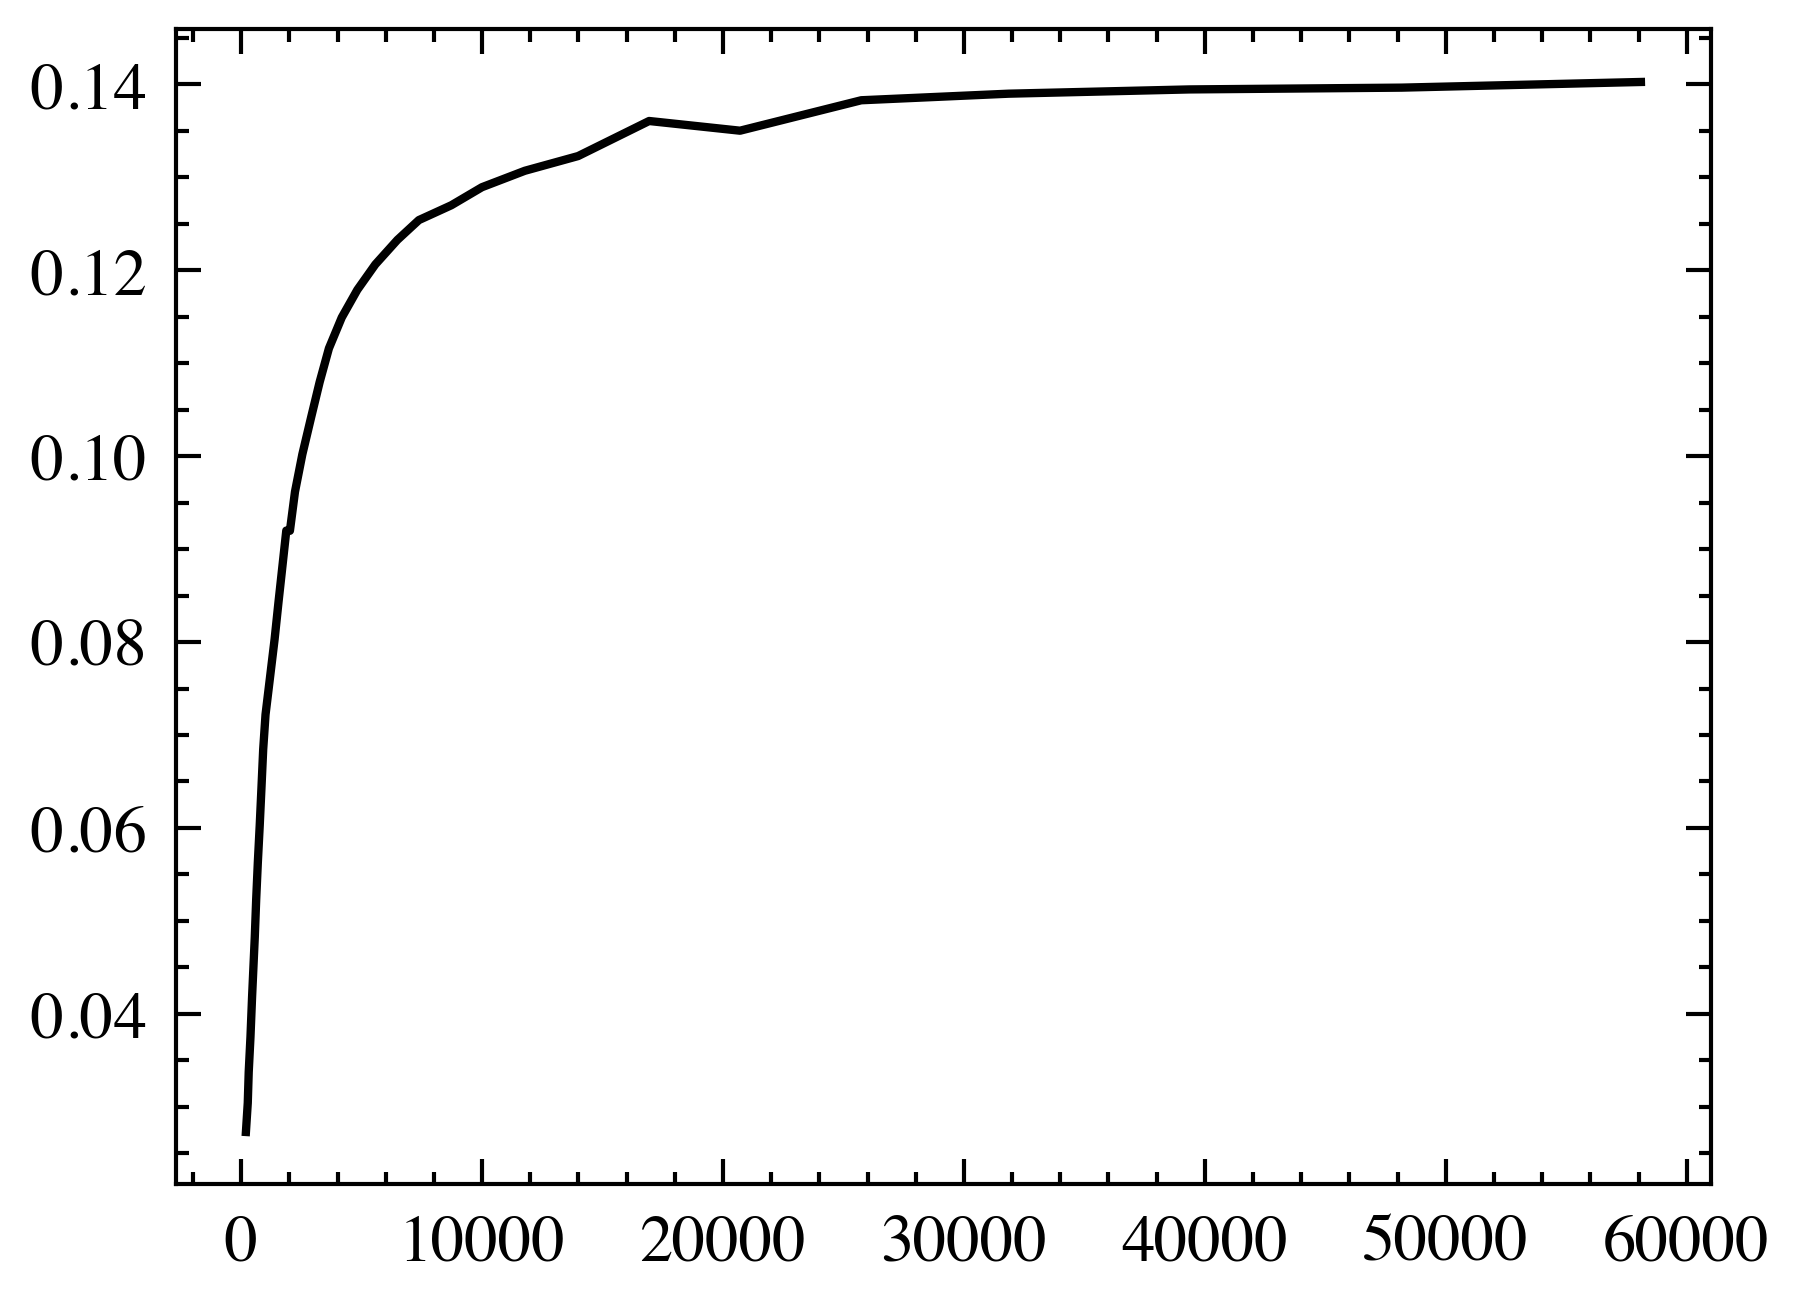

In [19]:
# Plot nz_cols and nz_cols2 vs pev_gravier and pev_christensen
plt.plot(nz_loads2, pev_christensen)
plt.plot(nz_loads, pev_gravier, label = 'Gravier')
